In [2]:
from typing import Tuple
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import jax
import jax.numpy as jnp
from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization
import cv2

max_num_objects = 32
config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
    path="./data/training_tfexample.tfrecord@5",
)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)
scenario = next(data_iter)

def construct_SDC_route(
    state,
):
    """Construct a SDC route from the logged trajectory. This is neccessary for the progression metric as WOMD doesn't release their routes.
    Args:
        state: The simulator state.
    Returns:
        The updated simulator state with the SDC route.
    """
    # Calculate arc lengths (cumulative distances along the trajectory)
    # Select sdc trajectory
    sdc_trajectory: datatypes.Trajectory = datatypes.select_by_onehot(
        state.log_trajectory,
        state.object_metadata.is_sdc,
        keepdims=True,
    )
    x = sdc_trajectory.x
    y = sdc_trajectory.y
    z = sdc_trajectory.z

    # Downsample trajectory coordinates by keeping every 3rd point
    stride = 10

    # Get downsampled coordinates
    x_downsampled = x[..., ::stride]
    y_downsampled = y[..., ::stride]
    z_downsampled = z[..., ::stride]

    # Check if last point needs to be added
    num_points = x.shape[-1]
    last_included = (num_points - 1) % stride == 0

    x = jnp.concatenate([x_downsampled, x[..., -1:]], axis=-1)
    y = jnp.concatenate([y_downsampled, y[..., -1:]], axis=-1)
    z = jnp.concatenate([z_downsampled, z[..., -1:]], axis=-1)

    # Calculate differences between consecutive points
    dx = jnp.diff(x, axis=-1)
    dy = jnp.diff(y, axis=-1)

    # Calculate Euclidean distance for each step
    step_distances = jnp.sqrt(dx**2 + dy**2)

    # Calculate cumulative distances
    arc_lengths = jnp.zeros_like(x)
    arc_lengths = arc_lengths.at[..., 1:].set(jnp.cumsum(step_distances, axis=-1))

    logged_route = datatypes.Paths(
        x=x,
        y=y,
        z=z,
        valid=jnp.array([[True] * len(x[0])]),
        arc_length=arc_lengths,
        on_route=jnp.array([[True]]),
        ids=jnp.array([[0] * len(x)]),  # Dummy ID
    )
    return dataclasses.replace(
        state,
        sdc_paths=logged_route,
    )

scenario = construct_SDC_route(scenario)

img = visualization.plot_simulator_state(scenario, use_log_traj=True)
imgs = []
ray_visualization = []
state = scenario


def ray_segment_intersection(
    ray_angle: jax.Array, start_points: jax.Array, segment_dirs: jax.Array
) -> jax.Array:
    """
    Calculate the intersection distances between a ray and line segments.

    Args:
        ray_angle: The angle of the ray (in radians).
        start_points: Array of shape (N, 2) for segment start points (x,y).
        segment_dirs: Array of shape (N, 2) for segment directions (dx, dy).

    Returns:
        Array of distances from origin to intersections. Returns 100.0 if no intersection.
    """
    # Calculate ray direction
    ray_dir_x = jnp.sin(ray_angle)
    ray_dir_y = jnp.cos(ray_angle)

    # Calculate segment direction
    segment_dir_x = segment_dirs[:, 0]
    segment_dir_y = segment_dirs[:, 1]

    # Calculate determinant for intersection test
    det = segment_dir_x * ray_dir_y - segment_dir_y * ray_dir_x

    # Avoid division by zero for parallel lines
    is_parallel = jnp.abs(det) < 1e-8
    det = jnp.where(is_parallel, 1.0, det)  # Avoid division by zero

    # Calculate t1 and t2 parameters
    t1 = (start_points[:, 0] * ray_dir_y - start_points[:, 1] * ray_dir_x) / det
    t2 = (start_points[:, 0] * segment_dir_y - start_points[:, 1] * segment_dir_x) / det

    # Check if intersection is within segment (0 <= t1 <= 1) and ray (t2 >= 0)
    valid_t1 = (t1 >= 0.0) & (t1 <= 1.0)
    valid_t2 = t2 >= 0.0

    # Combine intersection validity checks
    valid_intersection = valid_t1 & valid_t2 & ~is_parallel

    # Calculate intersection points and distances
    ix = start_points[:, 0] + t1 * segment_dir_x
    iy = start_points[:, 1] + t1 * segment_dir_y

    # Distance from origin to intersection point
    distances = jnp.sqrt(ix**2 + iy**2)

    # Make sure distances over 100 are not valid
    valid_intersection = valid_intersection & (distances < 100.0)
    
    # Return distance if valid intersection, otherwise 100.0
    return jnp.where(valid_intersection, distances, 100.0)


def find_closest_distance(
    i, initval: Tuple[jax.Array, datatypes.RoadgraphPoints, jax.Array]
):
    circogram, rg_points, ray_angles = initval
    ray_angle = ray_angles[i]

    # Only consider valid points
    candidate_points = rg_points.valid

    # Only consider road edge points
    candidate_points = candidate_points & (
        (rg_points.types == datatypes.MapElementIds.ROAD_EDGE_BOUNDARY)
        | (rg_points.types == datatypes.MapElementIds.ROAD_EDGE_MEDIAN)
        | (rg_points.types == datatypes.MapElementIds.ROAD_EDGE_UNKNOWN)
    )

    # If no valid points, return the default distance
    has_valid = jnp.any(candidate_points)

    # Create line segments from roadgraph points
    starting_points = jnp.stack([rg_points.x, rg_points.y], axis=1)
    dir_xy = jnp.stack([rg_points.dir_x, rg_points.dir_y], axis=1)

    # Calculate intersection distances
    intersection_distances = ray_segment_intersection(
        ray_angle, starting_points, dir_xy
    )
    masked_distances = jnp.where(candidate_points, intersection_distances, 100.0)

    # Find minimum distance among valid points
    min_distance = jnp.min(masked_distances)

    # Update only the i-th element and return the whole array
    circogram = circogram.at[i].set(jnp.where(has_valid, min_distance, circogram[i]))
    return circogram, rg_points, ray_angles


def create_circogram(observation: datatypes.Observation, num_rays: int) -> jax.Array:
    ray_angles = jnp.linspace(0, 2 * jnp.pi, num_rays, endpoint=False)
    rg_points = observation.roadgraph_static_points
    # For each ray angle, find the closest intersection
    circogram = jnp.full(num_rays, 100.0)  # Default max distance
    (
        circogram,
        _,
        _,
    ) = jax.lax.fori_loop(
        0,
        num_rays,
        find_closest_distance,
        (circogram, rg_points, ray_angles),
    )
    return circogram



jit_step = jax.jit(datatypes.update_state_by_log, static_argnums=(1,))
jit_observed = jax.jit(datatypes.sdc_observation_from_state, static_argnums=(1,2))
jit_create_circogram = jax.jit(create_circogram, static_argnums=(1))
for _ in tqdm(range(scenario.remaining_timesteps)):
    state = jit_step(state, num_steps=1)
    #imgs.append(visualization.plot_simulator_state(state, use_log_traj=True))
    imgs.append(
        visualization.plot_observation(
            jit_observed(state, roadgraph_top_k=2000),
            obj_idx=0
        )
    )

    num_rays = 64
    ray_angles = jnp.linspace(-jnp.pi, jnp.pi, num_rays, endpoint=False)
    observation = jit_observed(state, roadgraph_top_k=2000)
    circogram = jit_create_circogram(observation, num_rays)
    

  # Create a visualization of ray distances
    small_size = 500  # Size of the visualization image
    scale_factor = 5.0  # Scale factor for distance visualization
    x = small_size // 2  # Center of the image
    y = small_size // 2  # Center of the image
    ray_img = np.ones((small_size, small_size, 3), dtype=np.uint8) * 255  # White background
    center = (x, y)  # Center of the image

    # Draw rays
    for i in range(num_rays):
        # Calculate endpoint based on ray angle and distance
        angle = ray_angles[i]
        dist = circogram[i]

        # Scale the distance for visualization
        scaled_dist = dist * scale_factor

        # Calculate endpoint
        end_x = int(center[0] + np.sin(angle) * scaled_dist)
        end_y = int(center[1] + np.cos(angle) * scaled_dist)

        # Draw a line from center to endpoint
        cv2.line(ray_img, center, (end_x, end_y), (0, 0, 255), 1)  # Red lines

    # Add a circle for the SDC
    cv2.circle(ray_img, center, 5, (0, 255, 0), -1)  # Green circle for SDC

    # Flip the ray image upside down to match conventional coordinate system
    ray_img = cv2.flip(ray_img, 0)

    # Draw a reference circle at maximum range
    max_range_radius = int(100.0 * scale_factor)  # 100 meters reference
    cv2.circle(ray_img, center, max_range_radius, (200, 200, 200), 1)  # Gray circle
    # Add distance markers
    for dist in [20, 40, 60, 80]:
        radius = int(dist * scale_factor)
        cv2.circle(ray_img, center, radius, (220, 220, 220), 1, cv2.LINE_AA)
        # Add text label
        text_pos = (center[0] + 5, center[1] - radius - 5)
        cv2.putText(ray_img, f"{dist}m", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 
                    0.4, (100, 100, 100), 1, cv2.LINE_AA)

    # Add to ray_visualization array
    ray_visualization.append(ray_img)
mediapy.show_video(imgs, fps=10)
mediapy.show_video(ray_visualization, fps=10)



100%|██████████| 90/90 [00:52<00:00,  1.71it/s]


Selected point ID: 72
Selected point coordinates: [ 10.21875  -39.747437]
Minimum distance to another point with the same ID: 0.8847737312316895
Average distance between consecutive points in this group: 4.55879545211792


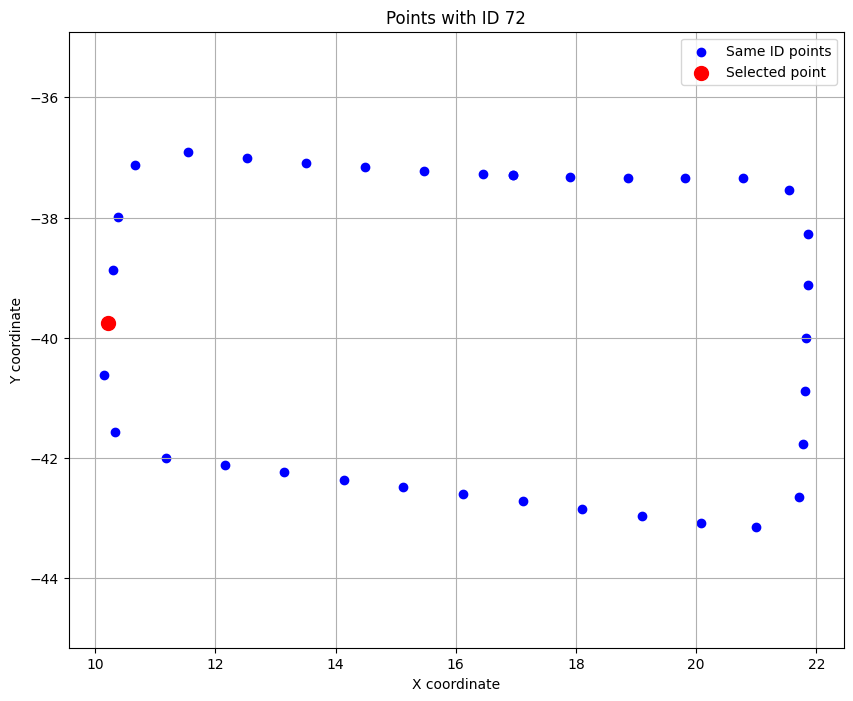

Distance to closest point of any ID: 0.8847736943531689
Minimum distance to a point with same type (15) but different ID: 8.067008018493652


In [9]:
from typing import Tuple
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import jax
import jax.numpy as jnp
from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization
import cv2
from collections import defaultdict
from scipy.spatial import KDTree
import numpy as np
from matplotlib import pyplot as plt

max_num_objects = 32
config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
    path="./data/training_tfexample.tfrecord@5",
)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)

observation = datatypes.sdc_observation_from_state(
    scenario, roadgraph_top_k=2000
)
rg_points = observation.roadgraph_static_points
rg_xy= rg_points.xy
ids = rg_points.ids

# Extract valid roadgraph points data
valid_mask = rg_points.valid[0]
valid_x = rg_points.x[0][valid_mask]
valid_y = rg_points.y[0][valid_mask]
valid_ids = rg_points.ids[0][valid_mask]
valid_types = rg_points.types[0][valid_mask]
valid_coords = np.column_stack((valid_x, valid_y))
valid_dirs = np.column_stack((rg_points.dir_x[0][valid_mask], rg_points.dir_y[0][valid_mask]))

# Group points by ID
points_by_id = defaultdict(list)
for i, (coord, id_val) in enumerate(zip(valid_coords, valid_ids)):
    points_by_id[int(id_val)].append((coord, i))

# Convert to numpy arrays for faster computation
points_arrays = {}
for id_val, points_list in points_by_id.items():
    if len(points_list) > 1:  # Only consider IDs with multiple points
        coords = np.array([p[0] for p in points_list])
        points_arrays[id_val] = coords

# Select a random ID that has multiple points
if points_arrays:
    point_id = np.random.choice(list(points_arrays.keys()))
    points = points_arrays[point_id]
    
    # Select a random point from this ID group
    point_idx = np.random.randint(len(points))
    point = points[point_idx]
    
    # Find other points with the same ID
    other_coords = np.delete(points, point_idx, axis=0)
    
    # Calculate distances from the selected point to other points with the same ID
    if len(other_coords) > 0:
        dists = np.sqrt(np.sum((other_coords - point)**2, axis=1))
        min_dist = np.min(dists)
        
        # Find average distance between consecutive points
        dists_between_consecutive = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        overall_avg = np.mean(dists_between_consecutive)
        
        print(f"Selected point ID: {point_id}")
        print(f"Selected point coordinates: {point}")
        print(f"Minimum distance to another point with the same ID: {min_dist}")
        print(f"Average distance between consecutive points in this group: {overall_avg}")
        
        # Create a visualization of all points with this ID
        plt.figure(figsize=(10, 8))
        plt.scatter(points[:, 0], points[:, 1], c='blue', label='Same ID points')
        plt.scatter(point[0], point[1], c='red', s=100, label='Selected point')
        plt.title(f"Points with ID {point_id}")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()
        
        # Build a KDTree for faster nearest neighbor search
        tree = KDTree(valid_coords)
        
        # Find points with the same type but different ID
        type_val = valid_types[points_by_id[point_id][0][1]]
        same_type_mask = valid_types == type_val
        different_id_mask = valid_ids != point_id
        same_type_diff_id_mask = same_type_mask & different_id_mask
        
        if np.any(same_type_diff_id_mask):
            same_type_diff_id_coords = valid_coords[same_type_diff_id_mask]
            dist, idx = tree.query(point, k=2)
            print(f"Distance to closest point of any ID: {dist[1]}")
            
            # Find closest point with same type but different ID
            same_type_dists = np.sqrt(np.sum((same_type_diff_id_coords - point)**2, axis=1))
            min_same_type_dist = np.min(same_type_dists)
            print(f"Minimum distance to a point with same type ({type_val}) but different ID: {min_same_type_dist}")
    else:
        print("No other points found with the same ID")
else:
    print("No IDs with multiple points found")